# Debugging QuantiCam.jl

- [ ] Firmware written on the board
- [ ] Test signals validated
- [ ] Run Matlab test for comparison
- [ ] Record test leads logical values and compare to QC.jl
- [ ] Add visualization toolbox
- [ ] Write experiment test scripts

In [1]:
using QuantiCam

In [59]:
QuantiCam.cleanup(qc)

[ Info: Disconnected from Sensor
[ Info: Cleaning up FPGA connection to OK FrontPanel
[ Info: FPGA desctructed! => Safe exit


┌ Error: Error watching manifest
│   exception =
│    TOML Parser error:
│    /home/cristi/Documents/Scripts/Julia/opal-kelly/QuantiCam/Manifest.toml:1388:35 error: string literal ended unexpectedly
│          GeometryBasics = "5c1252a2-5f3
│                                       ^ 
│    Stacktrace:
│     [1] parse
│       @ ./toml_parser.jl:449 [inlined]
│     [2] get_updated_dict(p::Base.TOML.Parser{nothing}, f::Base.CachedTOMLDict)
│       @ Base ./loading.jl:247
│     [3] (::Base.var"#1062#1063"{String, Base.TOMLCache{nothing}})()
│       @ Base ./loading.jl:292
│     [4] lock(f::Base.var"#1062#1063"{String, Base.TOMLCache{nothing}}, l::ReentrantLock)
│       @ Base ./lock.jl:232
│     [5] parsed_toml
│       @ ./loading.jl:279 [inlined]
│     [6] parsed_toml
│       @ ./loading.jl:277 [inlined]
│     [7] manifest_paths!(pkgpaths::Dict{Base.PkgId, String}, manifest_file::String)
│       @ Revise ~/.julia/packages/Revise/tTIBp/src/pkgs.jl:406
└ @ Revise ~/.julia/packages/Revise/tTIB

## Setup connection to the QC FPGA
- Write FW
- Config voltages
- Config sensor settings for the mode we use

In [5]:
if (@isdefined qc) && qc!== nothing
    #QuantiCam.sensor_disconnect(qc)
    QuantiCam.cleanup(qc)
end
qc = QCBoard("../hw/TOP_7310_modes_1_2.bit", "../config/tcspc.json")
init_board!(qc)

[ Info: Opal Kelly to API Comms setup in progress...


Scanning USB for Opal Kelly devices...
Found 1 Opal Kelly device(s)
Serial number of device 0 is 1908000OVV


[ Info: Device opened with id=Opal Kelly XEM7310 and board model=ok_brdXEM7310A200
[ Info: Located bit file ../hw/TOP_7310_modes_1_2.bit
[ Info: Firmware written successfuly
[ Info: Waiting on voltages to stabilize
[ Info: Connected to Sensor
[ Info: Initialize logic parameters necessary to interact with the sensor
[ Info: Reset sensor and set parameters for the MODE of use
[ Info: Sensor configured


## Capture

Next we have a few different methods to read from the sensor and display or save the data

### One frame visualize
Just read one frame and display it

In [40]:
println("Reading a frame with el_size=$(QuantiCam.element_size(qc)) and frame_size=$(QuantiCam.frame_size(qc))")
frame = QuantiCam.capture_raw(qc);
size(frame)

Reading a frame with el_size=1 and frame_size=24576


[ Info: Reading block packet_size=256, frame_size=24576


(24576,)

In [ ]:
row_pairs = QuantiCam.partition_row_pairs(frame, qc.config.rows, qc.config.cols; el_size=element_size(qc))
function filter_code(tdc_pixels::Union{Array{UInt8}, Array{UInt16}})
  nan_boxed_pixels = similar(tdc_pixels, Float32)
  nan_boxed_pixels = map(x-> if(x==0x04) missing else Float32(x) end, tdc_pixels)
  nan_boxed_pixels
end
filter_code(frame)  

24576-element Vector{Union{Missing, Float32}}:
   0.0
   0.0
   1.0
 128.0
    missing
  60.0
    missing
    missing
    missing
    missing
    missing
  20.0
    missing
   ⋮
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing

In [8]:
println(typeof(frame))
println(size(frame))
println(QuantiCam.element_size(qc))
println(size(row_pairs))
println(size(row_pairs[1]))
println(size(row_pairs[2]))

Vector{UInt8}
(24576,)
1
(96,)
(256,)
(256,)


In [9]:
marker_idx = findall(frame .== 0x80)
for idx in marker_idx
    println("Match at $idx header is: $(frame[idx-3:idx]))")
end

Match at 4 header is: UInt8[0x00, 0x00, 0x01, 0x80])
Match at 260 header is: UInt8[0x01, 0x00, 0x01, 0x80])
Match at 516 header is: UInt8[0x02, 0x00, 0x01, 0x80])
Match at 772 header is: UInt8[0x03, 0x00, 0x01, 0x80])
Match at 1028 header is: UInt8[0x04, 0x00, 0x01, 0x80])
Match at 1284 header is: UInt8[0x05, 0x00, 0x01, 0x80])
Match at 1540 header is: UInt8[0x06, 0x00, 0x01, 0x80])
Match at 1796 header is: UInt8[0x07, 0x00, 0x01, 0x80])
Match at 2052 header is: UInt8[0x08, 0x00, 0x01, 0x80])
Match at 2308 header is: UInt8[0x09, 0x00, 0x01, 0x80])
Match at 2564 header is: UInt8[0x0a, 0x00, 0x01, 0x80])
Match at 2820 header is: UInt8[0x0b, 0x00, 0x01, 0x80])
Match at 3076 header is: UInt8[0x0c, 0x00, 0x01, 0x80])
Match at 3332 header is: UInt8[0x0d, 0x00, 0x01, 0x80])
Match at 3588 header is: UInt8[0x0e, 0x00, 0x01, 0x80])
Match at 3844 header is: UInt8[0x0f, 0x00, 0x01, 0x80])
Match at 4100 header is: UInt8[0x10, 0x00, 0x01, 0x80])
Match at 4356 header is: UInt8[0x11, 0x00, 0x01, 0x80]

In [22]:
trig_pixels = findall(frame .!= 0x04)
findall(x->x==258, trig_pixels)

1-element Vector{Int64}:
 28

In [23]:
row_pairs .!=0x04

96-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

[ Info: Reading block packet_size=256, frame_size=24576


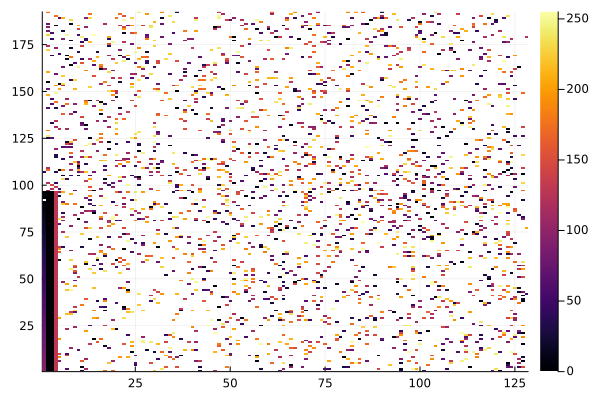

In [51]:
using Plots
frame = QuantiCam.capture_frame(qc)
frame_filtered = filter_code(frame)
heatmap(frame_filtered)

In [223]:
QuantiCam.reload_config(qc, "../config/tcspc.json")
QuantiCam.config_sensor(qc)

[ Info: Reset sensor and set parameters for the MODE of use
[ Info: Sensor configured


## TCSPC Histogram
- [ ] Aquire N tcspc frames
- [ ] Make histogram for each pixel

In [52]:
frames = QuantiCam.capture_frames(qc, 10000)
size(frames)

[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_size=24576
[ Info: Reading block packet_size=256, frame_siz

(10000,)

In [53]:
filtered_frames = map(filter_code, frames)

10000-element Vector{Matrix{Union{Missing, Float32}}}:
 [missing missing … missing missing; missing 12.0 … missing missing; … ; missing missing … missing missing; missing missing … missing missing]
 [missing missing … 150.0 missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing]
 [missing 54.0 … missing missing; missing missing … 94.0 missing; … ; missing missing … 83.0 missing; missing missing … missing missing]
 [missing missing … missing missing; missing missing … missing missing; … ; 11.0 missing … missing missing; missing missing … missing missing]
 [missing missing … missing missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing]
 [missing 27.0 … missing missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing]
 [44.0 missing … missing missing; missing missing … missing missing; … ; missing missing 

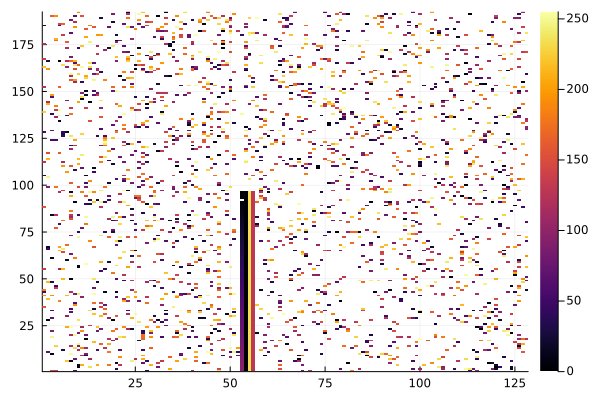

In [56]:
heatmap(filtered_frames[13])

In [54]:
using Statistics

function collect_frames(v::Vector{Matrix{T}}) where T
    n_rows = size(v[1], 1)
    n_cols = size(v[1], 2)
    n_matrices = length(v)
    
    result = Matrix{Vector{T}}(undef, n_rows, n_cols)
    
    for i in 1:n_rows, j in 1:n_cols
        result[i, j] = [v[k][i, j] for k in 1:n_matrices]
    end
    
    return result
end

tcspc_stream = collect_frames(filtered_frames)
tcspc_mean = mean(filtered_frames)
tcspc_var = var(filtered_frames)

192×128 Matrix{Union{Missing, Float32}}:
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  m

In [ ]:
using SparseArrays
row_indices, col_indices = findnz(sparse(tcspc_var .> 500))
for (row, col) in zip(row_indices, col_indices)
    if (row> 50 && row < 100)
        println("$row, $col")
    end
end

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///home/cristi/Documents/Scripts/Julia/opal-kelly/QuantiCam/examples/In[266]#6:4\[90mIn[266]:6:4[0;0m]8;;\
    println("$row, $col")
end[48;2;120;70;70m[0;0m
[90m#  └ ── [0;0m[91mExpected `end`[0;0m

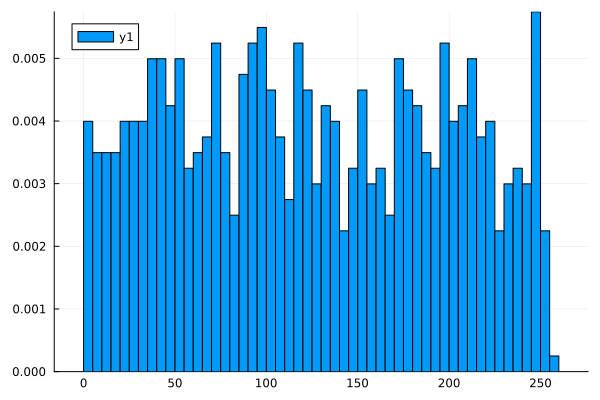

In [58]:
histogram(tcspc_stream[177, 3], bins=100, normalize=:pdf)

In [38]:
tcspc_stream[100,100]

10000-element Vector{UInt16}:
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
      ⋮
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004
 0x0004

In [222]:
(40e-2 / 3e8) * 10^9

1.3333333333333335